### AMS 520 Kernel Learning Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import collections
from itertools import chain
from matplotlib.dates import DateFormatter
path='/home/jbohn/jupyter/personal/sbu/Kernel_Learning'

sys.path.append(path)

# Data Set
- Trade and Quote Data for AAPL on NASDAQ between 01/01/2020 and 01/30/2020

### Preprocessing
- Removed trades outside of market hours and timestamp realignment


In [2]:
def clean_trades(trades):

    # parse date and pt
    trades["date"] = trades["Time"].apply(lambda x: str(x[:11]))
    trades.index = trades["date"] + trades["Participant_Timestamp"].astype(str)
    trades = trades.drop(columns=["Participant_Timestamp"])
    trades = trades.rename(
        columns={trades.columns[0]: "Participant_Timestamp", "Time": "SIP_Timestamp"}
    )
    
    
    trades.index = trades.index.str[:-3]
    time = pd.Series(
        pd.to_datetime(trades.index.str[11:].str.zfill(12), format="%H%M%S%f")
    )
    date = pd.Series(pd.to_datetime(trades.index.str[:11]))
    trades.index = date.apply(lambda x: x) + time.apply(
        lambda x: timedelta(
            hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond
        )
    )

    trades = trades.sort_index()

    trades = trades.dropna(axis=1, how="all")

    trades=trades[trades['Trade_Volume']>0]
    
    trades=trades[trades['Trade_Price']>0]
    
    grouped_trades = trades.groupby("date").groups

    # drop trade data outside of market hours

    for day in grouped_trades.keys():
        subset = trades[trades["date"] == day]
        grouped_trades[day] = subset[
            subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
        ]
        grouped_trades[day] = subset[
            subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
        ]

    new_trades = pd.concat(list(grouped_trades.values())).sort_index()

    return new_trades



def clean_quotes(quotes, drop_after_hours=True):

    # parse date and pt
    quotes["date"] = quotes["Time"].apply(lambda x: str(x[:11]))
    quotes.index = quotes["date"] + quotes["Participant_Timestamp"].astype(str)
    quotes = quotes.drop(columns=["Participant_Timestamp", "date"])
    quotes = quotes.rename(
        columns={quotes.columns[0]: "Participant_Timestamp", "Time": "SIP_Timestamp"}
    )

    # convert pt to valid ts
    quotes.index = quotes.index.str[:-3]
    time = pd.Series(
        pd.to_datetime(quotes.index.str[11:].str.zfill(12), format="%H%M%S%f")
    )
    date = pd.Series(pd.to_datetime(quotes.index.str[:11]))
    quotes.index = date.apply(lambda x: x) + time.apply(
        lambda x: timedelta(
            hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond
        )
    )

    quotes = quotes.sort_index()

    quotes = quotes.dropna(axis=1, how="all")

    quotes = quotes[
        quotes["Offer_Price"] > quotes["Bid_Price"]
    ]  # removed quotes with invalid spreads
    quotes = quotes[quotes["Bid_Price"] > 0]  # bid and offer price >0

    # drop after hours for quotes, preserve if want to prepend lob
    if drop_after_hours:
        quotes["date"] = quotes.index.date

        grouped_quotes = quotes.groupby("date").groups

        # drop trade data outside of market hours

        for day in grouped_quotes.keys():
            subset = quotes[quotes["date"] == day]
            grouped_quotes[day] = subset[
                subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
            ]
            grouped_quotes[day] = subset[
                subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
            ]
        new_quotes = pd.concat(list(grouped_quotes.values())).sort_index()

        return new_quotes
    else:
        return quotes

### Trade Features


In [3]:
trades=pd.read_csv(f"{path}/data/AAPL_trades.csv")
trades=clean_trades(trades)
trades

,SIP_Timestamp,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Trade_Reporting_Facility,Trade_Through_Exempt_Indicator,date
2020-01-15 09:30:01.004096,2020-01-15 09:30:01.004475,N,AAPL,100,311.94,@F,N,0,25659,5,,1,2020-01-15
2020-01-15 09:30:01.100463,2020-01-15 09:30:01.100841,N,AAPL,3,311.91,@F I,N,0,26087,6,,1,2020-01-15
2020-01-15 09:30:01.438061,2020-01-15 09:30:01.438450,N,AAPL,10,311.89,@ I,N,0,26776,7,,0,2020-01-15
2020-01-15 09:30:01.438068,2020-01-15 09:30:01.438451,N,AAPL,46,311.89,@ I,N,0,26777,8,,0,2020-01-15
2020-01-15 09:30:01.677976,2020-01-15 09:30:01.678356,N,AAPL,1,311.95,@ I,N,0,27223,9,,0,2020-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-29 15:59:53.740641,2020-01-29 15:59:53.741022,N,AAPL,200,324.19,@,N,0,3176877,5537,,0,2020-01-29
2020-01-29 15:59:54.201995,2020-01-29 15:59:54.202375,N,AAPL,7,324.20,@F I,N,0,3177673,5538,,1,2020-01-29
2020-01-29 15:59:54.211207,2020-01-29 15:59:54.211587,N,AAPL,18,324.15,@F I,N,0,3177713,5539,,1,2020-01-29
2020-01-29 15:59:55.696931,2020-01-29 15:59:55.697308,N,AAPL,3,324.26,@ I,N,0,3179653,5540,,0,2020-01-29


In [4]:
sample_trades=trades.copy()

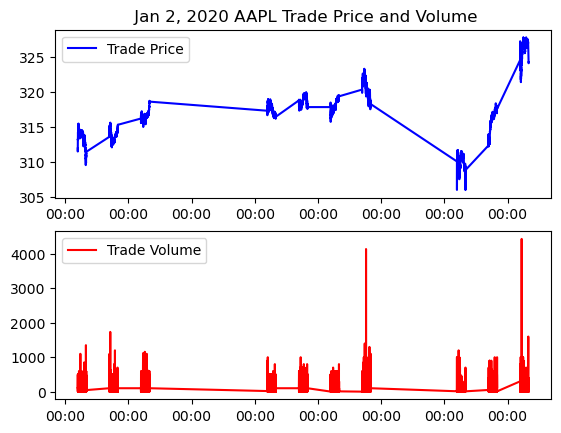

In [5]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_trades["Trade_Price"],label='Trade Price',color='blue')
ax[1].plot(sample_trades["Trade_Volume"],label='Trade Volume',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Trade Price and Volume")
ax[0].legend()
ax[1].legend()

### Examine properties of Trades
    - @ : Regular Trade
    - @F : Regular Intermarket Sweep
    - @I : Regular Odd Lot
    - @IF: Regular Odd Lot Intermarket Sweep

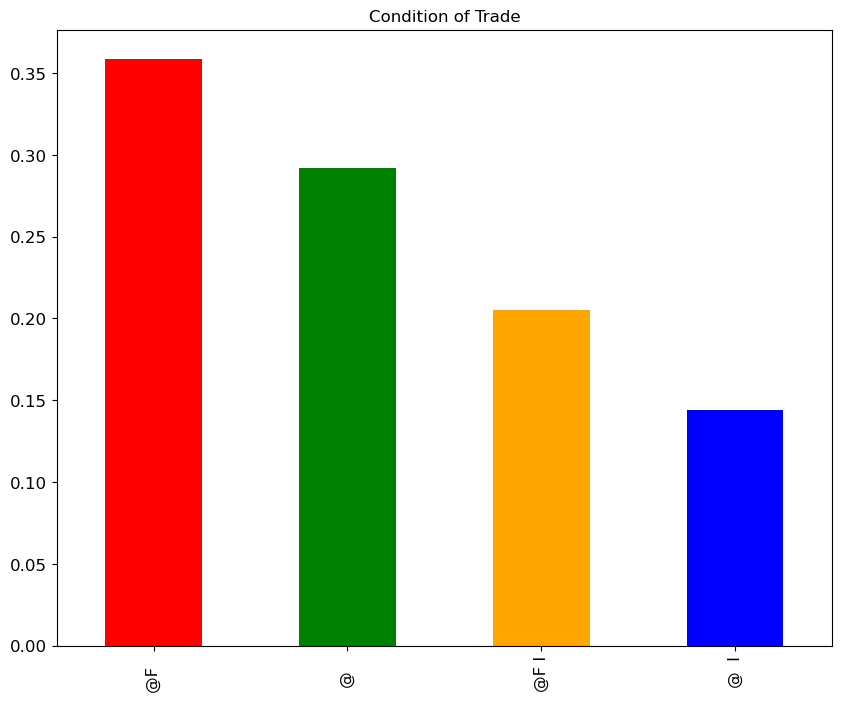

In [6]:
my_colors = c = ['red', 'green', 'orange', 'blue']
ax = (trades['Sale_Condition'].value_counts()/trades.shape[0]).plot(kind='bar', title ="Condition of Trade", figsize=(10,8),  fontsize=12,color=my_colors)

(array([3.8350e+03, 1.6580e+03, 2.1690e+03, 3.1740e+03, 4.4910e+03,
        2.6526e+04, 9.8760e+03, 1.6920e+03, 5.1000e+01, 2.0000e+00]),
 array([0.        , 0.83972829, 1.67945658, 2.51918487, 3.35891316,
        4.19864145, 5.03836974, 5.87809803, 6.71782632, 7.55755461,
        8.39728289]),
 <BarContainer object of 10 artists>)

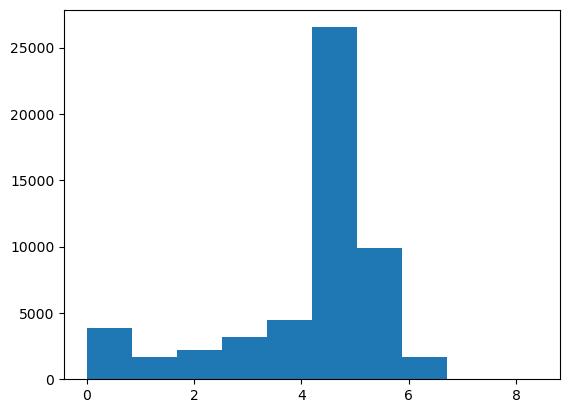

In [7]:
plt.hist(np.log(trades['Trade_Volume']))

### Quote Features

- CleanQuotes correctly aligned according to participant ts

In [8]:
quotes=pd.read_csv(f"{path}/data/AAPL_quotes.csv",nrows=1000000)
quotes=clean_quotes(quotes)
quotes.to_csv('data/cleaned_quotes.csv')

In [9]:
quotes

,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,Source_Of_Quote,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,National_BBO_Ind,date
2020-01-15 09:30:00.953633,2020-01-15 09:30:00.954013,N,AAPL,311.94,1.0,326.18,1.0,R,356546,N,N,311.94,1.0,V,311.96,1.0,A,,2,2020-01-15
2020-01-15 09:30:01.004096,2020-01-15 09:30:01.004476,N,AAPL,310.85,1.0,326.18,1.0,R,357650,N,Q,311.92,2.0,Q,311.99,1.0,A,,2,2020-01-15
2020-01-15 09:30:01.076382,2020-01-15 09:30:01.076759,N,AAPL,310.85,1.0,311.96,1.0,R,358817,N,Q,311.89,3.0,N,311.96,1.0,A,,2,2020-01-15
2020-01-15 09:30:01.645062,2020-01-15 09:30:01.645440,N,AAPL,310.85,1.0,311.95,4.0,R,363970,N,Q,311.90,1.0,N,311.95,4.0,A,,2,2020-01-15
2020-01-15 09:30:01.677976,2020-01-15 09:30:01.678357,N,AAPL,310.85,1.0,311.95,3.0,R,364328,N,P,311.86,2.0,N,311.95,3.0,A,,2,2020-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-29 15:59:37.990504,2020-01-29 15:59:37.990881,N,AAPL,324.10,1.0,324.60,1.0,R,31890276,N,Q,324.34,1.0,Q,324.39,1.0,A,,2,2020-01-29
2020-01-29 15:59:42.591204,2020-01-29 15:59:42.591582,N,AAPL,324.05,3.0,324.28,1.0,R,31920111,N,Q,324.23,1.0,Q,324.28,1.0,A,,2,2020-01-29
2020-01-29 15:59:51.441479,2020-01-29 15:59:51.441858,N,AAPL,323.97,1.0,324.27,1.0,R,31971787,N,Q,324.20,1.0,Q,324.27,2.0,A,,2,2020-01-29
2020-01-29 15:59:52.555595,2020-01-29 15:59:52.555972,N,AAPL,323.97,1.0,324.23,1.0,R,31978303,N,Q,324.17,2.0,N,324.23,1.0,A,,2,2020-01-29


In [10]:
sample_quotes=quotes.copy()

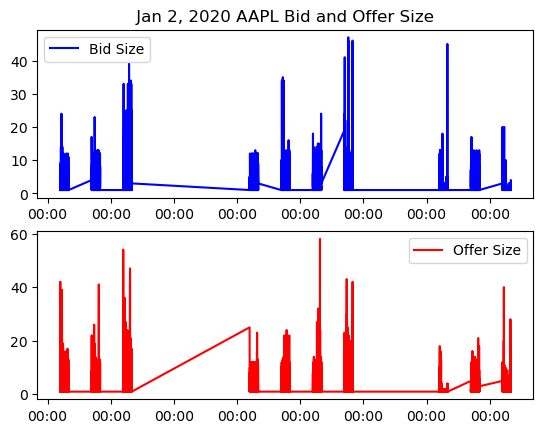

In [11]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_quotes['Bid_Size'],label='Bid Size',color='blue')
ax[1].plot(sample_quotes['Offer_Size'],label='Offer Size',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Bid and Offer Size ")
ax[0].legend()
ax[1].legend()

In [12]:
bid_percent=(quotes['Bid_Price']<quotes['Best_Bid_Price']).sum()/len(quotes['Bid_Price'])
ask_percent=(quotes['Offer_Price']>quotes['Best_Offer_Price']).sum()/len(quotes['Offer_Price'])

print (bid_percent,ask_percent)

0.5622003890715194 0.5122324138744972


### Investigation into Latency between Timestamps